# Advance Line Finding Poject

Main goal of this project is to estimate road curvature radious from road lines using a camera on the center-front of the car.

To accomplish such task, the following steps need to be completed:

 * Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
 * Apply a distortion correction to raw images.
 * Use color transforms, gradients, etc., to create a thresholded binary image.
 * Apply a perspective transform to rectify binary image ("birds-eye view").
 * Detect lane pixels and fit to find the lane boundary.
 * Determine the curvature of the lane and vehicle position with respect to center.
 * Warp the detected lane boundaries back onto the original image.
 * Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Camera Calibration:

In order to calibrate the image camera and reduce to a minimum level the image distorsions (to calculate road curvature from lines we need undistorted images!), a chessboard image from the camera is used. Since a chessboard has a defined and well known shape, [OpenCV includes libraries to easily identify corners in the distorted image and calculate the required corrections to undistort the image](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html). To perform this task, it is used the function:

```calibrate_camera```

This function process a bunch of images of a chessboard taken from different angles&distances to calculate the position of the chessboard inner corners in the calibration images. This information is later used in the ```cal_undistort``` to generate an undistorted image from a distorted one.

Let's import the required libraries for the project:

In [1]:
from imageutils import *
from params import *
%matplotlib inline

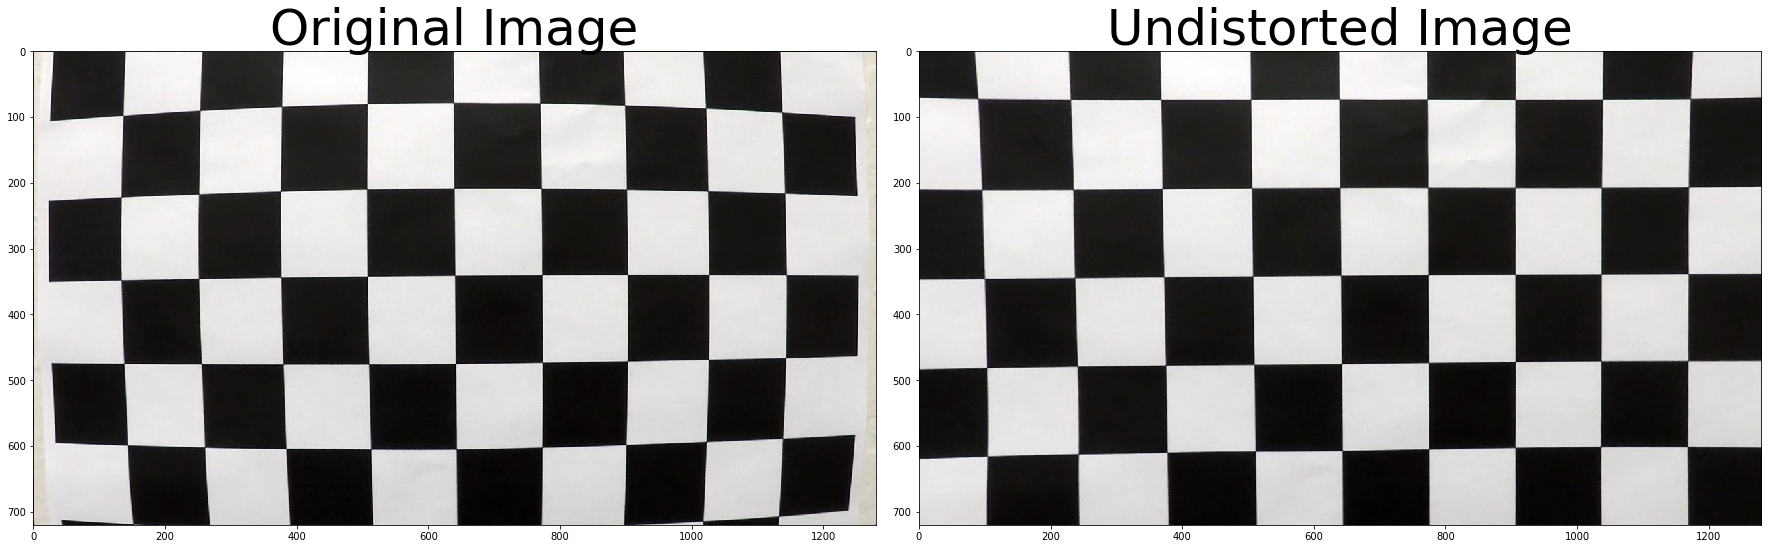

In [3]:
# Load path to calibration images and inner corners of the chessboard images:
nx = 9
ny = 6

# calculate object and image points:
objpoints, imgpoints = calibrate_camera(PATH_TO_CAMERA_CAL, nx, ny)

# Load an image for testing purposes:
fname = PATH_TO_CAMERA_CAL + 'calibration1.jpg'
img = mpimg.imread(fname)

# undistord image and show results:
undistorted = cal_undistort(img, objpoints, imgpoints)

# generate plot:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
plt.savefig('images/test.png')

Of course, this technique now can be used to raw camera images to correct them, for example:

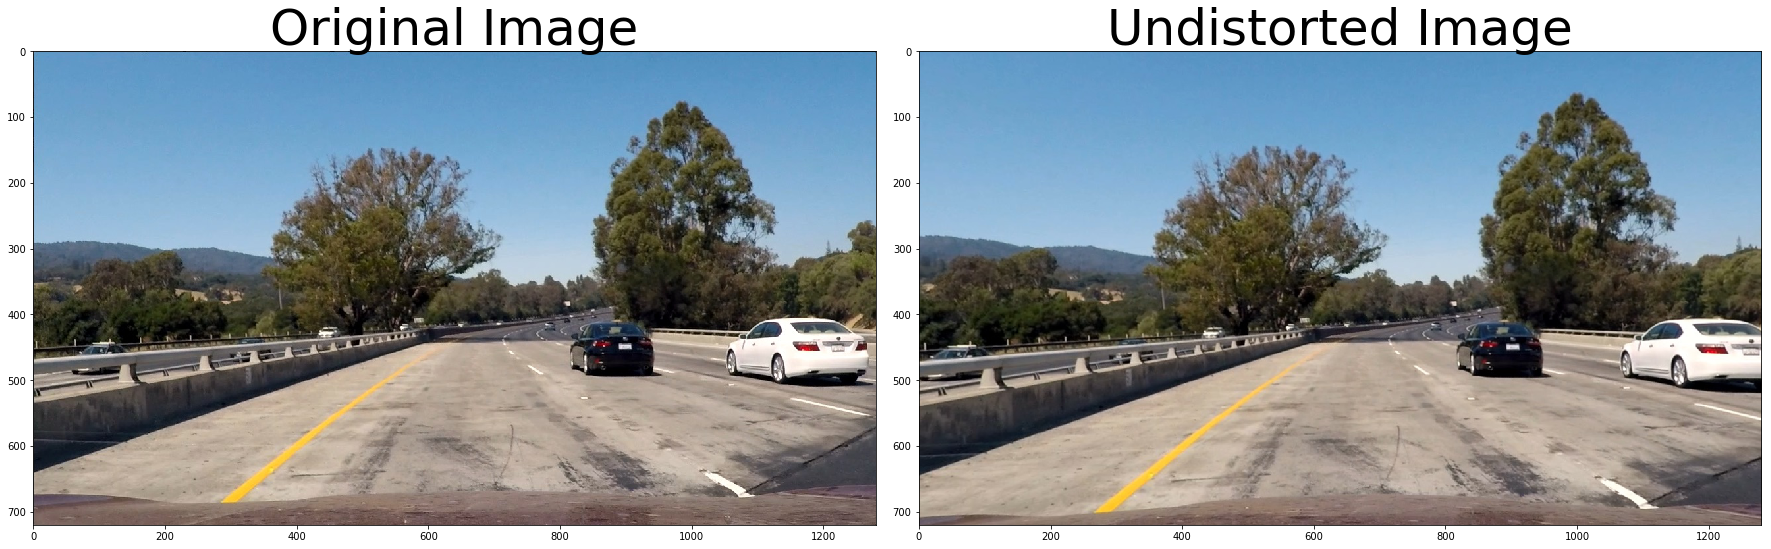

In [5]:
# Load an image for testing purposes:
fname = PATH_TO_EXAMPLE_FILES + 'test1.jpg'
img = mpimg.imread(fname)

# undistord image and show results:
undistorted = cal_undistort(img, objpoints, imgpoints)

# generate plot:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
plt.savefig('images/raw_undistorted.png')

## Color and Gradients transformations:
In order to isolate those pixels that are more likely to be part of the road lines, we apply color and gradients transformations. 

For the gradients transformation, we use the Sobel operator from the Canny edge detection algorithm. Three different transformations are included:
 * ```abs_sobel_thresh```: Sobel transformation in x or y directions
 * ```mag_sobel_thresh```: Sobel gradient magnitude
 * ```dir_sobel_threshold```: Sobel gradient direction
 
For a raw picture, these transformations looks like:

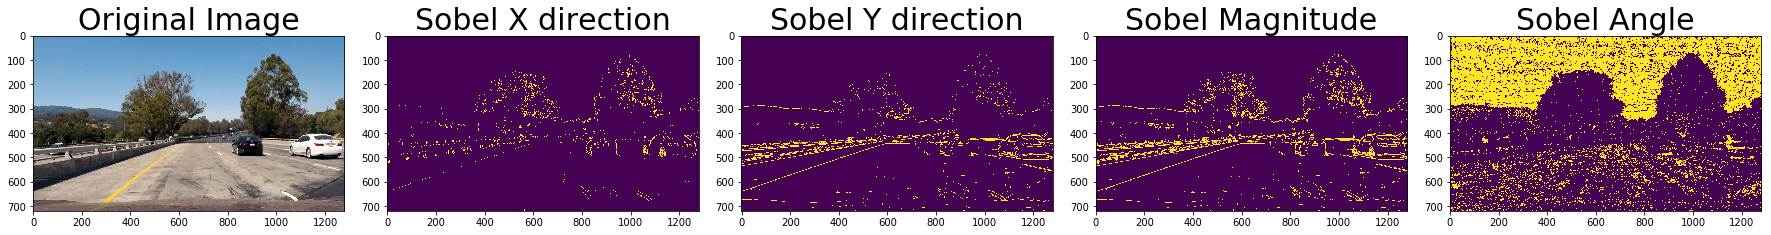

In [6]:
# Load an image for testing purposes:
fname = PATH_TO_EXAMPLE_FILES + 'test1.jpg'
img = mpimg.imread(fname)

# generate plot:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(40, 255)))
ax2.set_title('Sobel X direction', fontsize=30)
ax3.imshow(abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(40, 255)))
ax3.set_title('Sobel Y direction', fontsize=30)
ax4.imshow(mag_sobel_thresh(img, sobel_kernel=3, mag_thresh=(40, 255)))
ax4.set_title('Sobel Magnitude', fontsize=30)
ax5.imshow(mag_sobel_thresh(img, sobel_kernel=3, mag_thresh=(-1*np.pi/2, np.pi/2)))
ax5.set_title('Sobel Angle', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
plt.savefig('images/sobel_transformations.png')

Along with these Gradient transformations, there are some color transformations. RGB images are transformed to HLS channels:

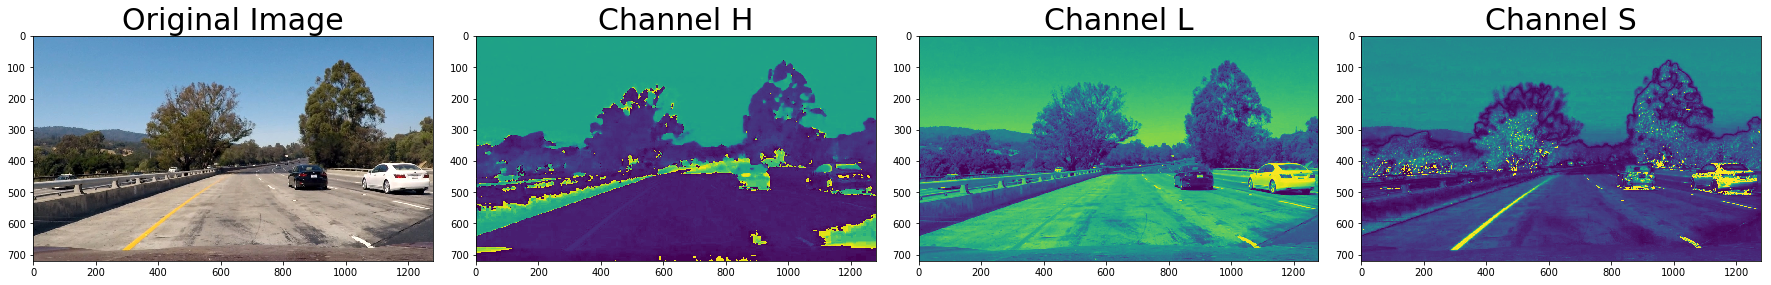

In [8]:
# Load an image for testing purposes:
fname = PATH_TO_EXAMPLE_FILES + 'test1.jpg'
img = mpimg.imread(fname)

# generate plot:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(channel_select(img, 0))
ax2.set_title('Channel H', fontsize=30)
ax3.imshow(channel_select(img, 1))
ax3.set_title('Channel L', fontsize=30)
ax4.imshow(channel_select(img, 2))
ax4.set_title('Channel S', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
plt.savefig('images/color_transformations.png')

Obviously Channel S seems to do a good job in this task!

To end, colors and gradients transformations are combined into a single pipeline. For the gradient transformation it is used the Channel L and Sobel Magnitude transformation and for the color, the Channel S.

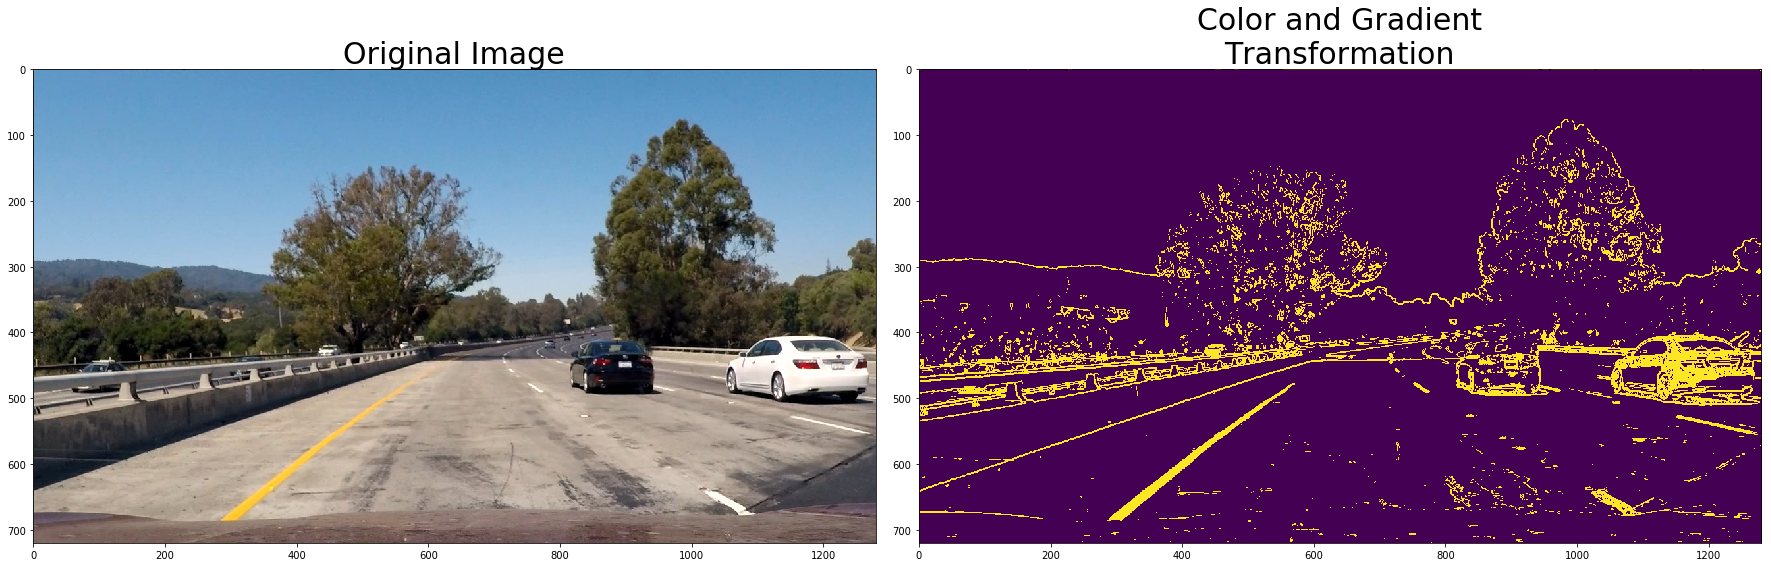

In [9]:
# Load an image for testing purposes:
fname = PATH_TO_EXAMPLE_FILES + 'test1.jpg'
img = mpimg.imread(fname)

# generate plot:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(color_gradient_pipeline(img, s_thresh=(170, 255), sobel_thres=(40, 250)))
ax2.set_title('Color and Gradient\nTransformation', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
plt.savefig('images/color_gradient_transformations.png')

## Perspective Transform 
Car images are in a perspective that make it dificult to calculate the road curvature radious. For such reason, a perspective transformation is used to get an "birds-eye view" of the road and so a bettwer perspective to calculate road curvature. 

**IMPORTANT:** For a correct calibration, let's use only straight lines

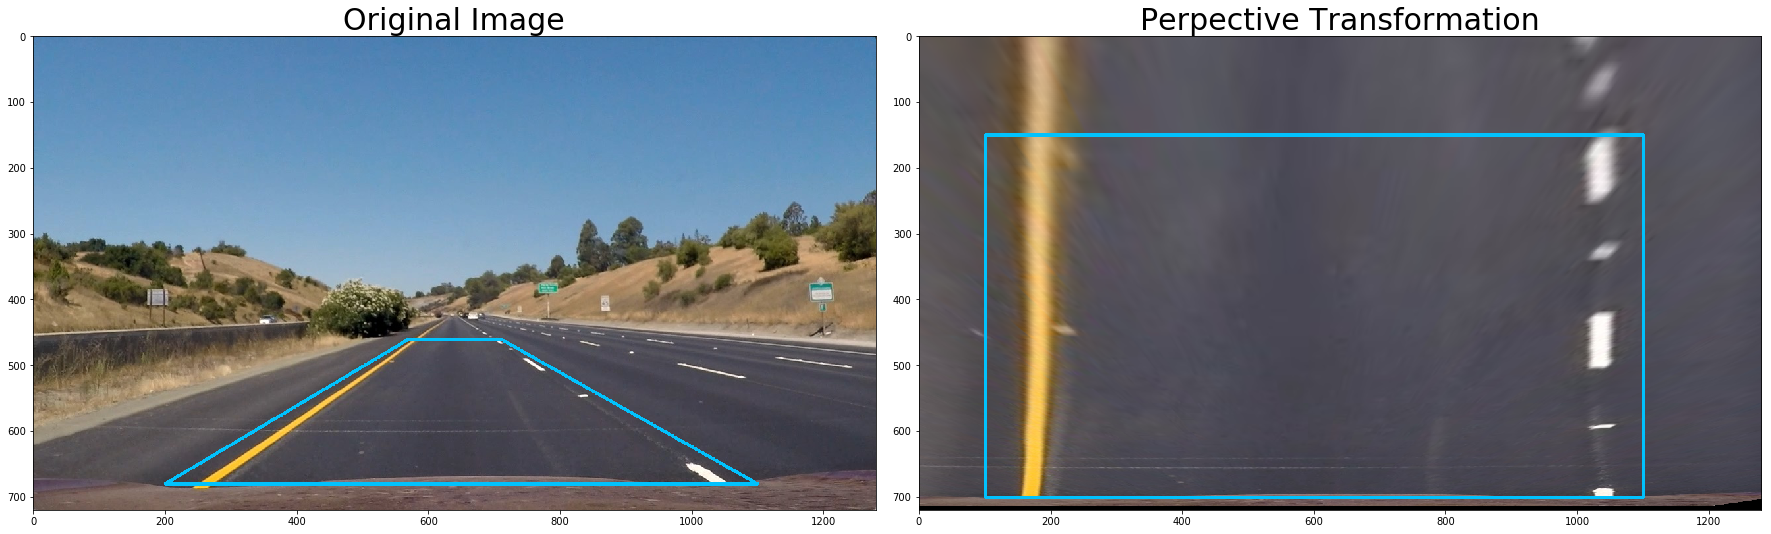

In [53]:
# Load an image for testing purposes:
fname = PATH_TO_EXAMPLE_FILES + 'straight_lines1.jpg'
img = mpimg.imread(fname)

img_original = np.copy(img)

# generate plot:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
cv2.polylines(img, [vertices], 1, (1,194,253), 4)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
img_transformed = perspective_transformation(img_original, np.float32(vertices), np.float32(vertices_transformed))
cv2.polylines(img_transformed, [vertices_transformed], 1, (1,194,253), 4)
ax2.imshow(img_transformed)
ax2.set_title('Perpective Transformation', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
plt.savefig('images/perspective_transformations.png')



This technique is now applied over the transformed images:

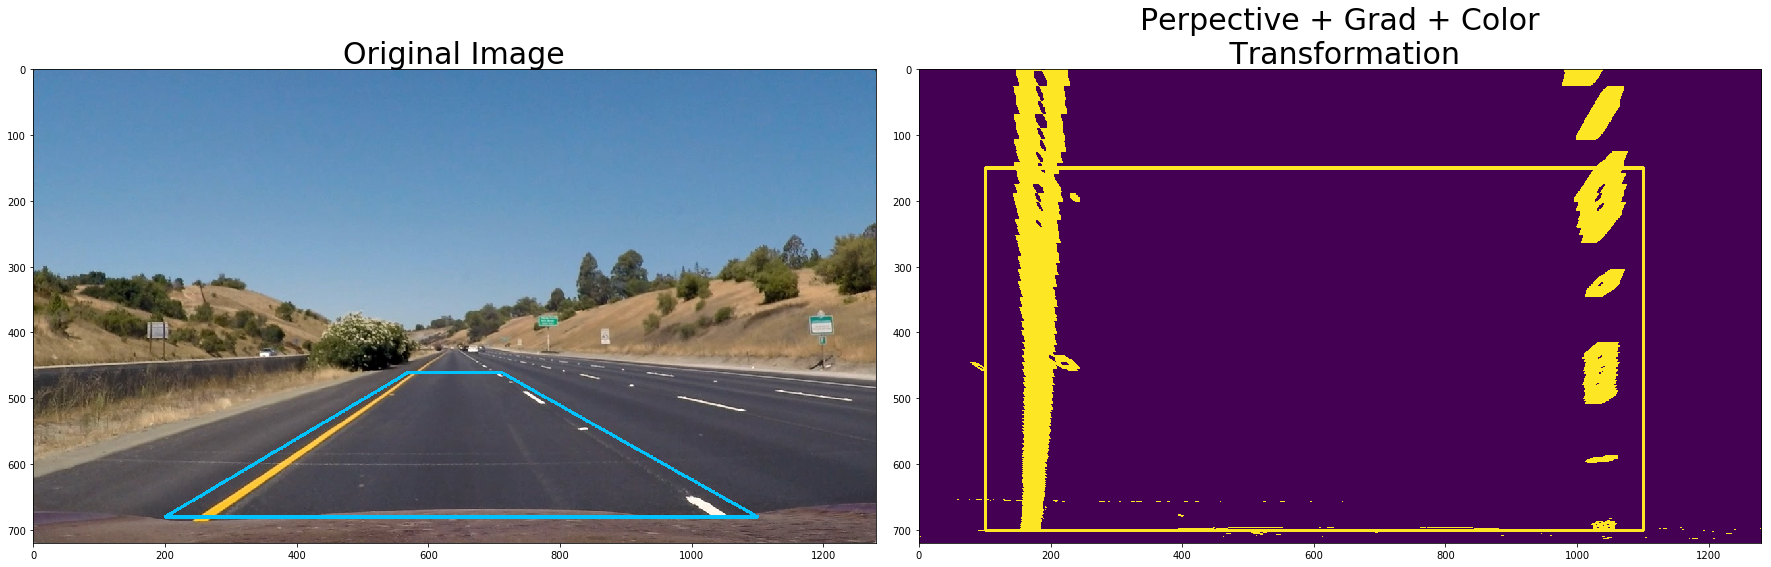

In [54]:
# Load an image for testing purposes:
fname = PATH_TO_EXAMPLE_FILES + 'straight_lines1.jpg'#'test6.jpg'
img = mpimg.imread(fname)

img_original = np.copy(img)

# generate plot:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
cv2.polylines(img, [vertices], 1, (1,194,253), 4)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
img_transformed = color_gradient_pipeline(img_original, s_thresh=(170, 255), sobel_thres=(40, 250))
img_transformed = perspective_transformation(img_transformed, np.float32(vertices), np.float32(vertices_transformed))
cv2.polylines(img_transformed, [vertices_transformed], 1, (1,194,253), 4)
ax2.imshow(img_transformed)
ax2.set_title('Perpective + Grad + Color\n Transformation', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('images/perspective_grad_color_transformations.png')
plt.show()


## Detect Line Pixels
All these transformations are going to facilitate the road lines identification and fit to a curve to be used to calculate the road radious.


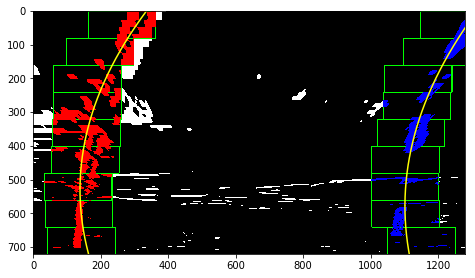

In [55]:
# Load an image for testing purposes:
fname = 'CarND-Advanced-Lane-Lines/test_images/test5.jpg'
img = mpimg.imread(fname)
nwindows = 9

img_transformed = color_gradient_pipeline(img, s_thresh=(170, 255), sobel_thres=(40, 250))
img_transformed = perspective_transformation(img_transformed, np.float32(vertices), np.float32(vertices_transformed))

out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fit, right_fit, \
           leftx_current, rightx_current, leftx, rightx, lefty, righty = identify_lines(img_transformed)

# Generate x and y values for plotting
ploty = np.linspace(0, img_transformed.shape[0]-1, img_transformed.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# add lines to image:
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
plt.savefig('images/lines_identification.png')

## Measuring Curvature:
At this stage, we are ready to measure road curvature since road lines are already identified and fitted. For this purpose, we need to extrapolate real dimensions to the transformed image to understand how many meters is a pixel. For this conversion, it is used the line wide for the x direction and line length for the y direction: 

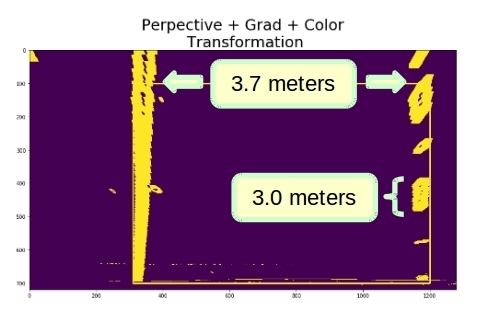

In [56]:
from IPython.display import Image
Image(filename='images/road_dimensions_in_projection.jpg')

In [57]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)

print("Left and Right Curvatures: ", measure_curvature(y_eval, lefty, righty, leftx, rightx, leftx_current, rightx_current, img_transformed.shape))



Left and Right Curvatures:  (135.69999999999999, 148.75, -0.67)


## Final Result:
All the required information is now calculated, so we are ready to process real time images and include the curvature information along with the line position:


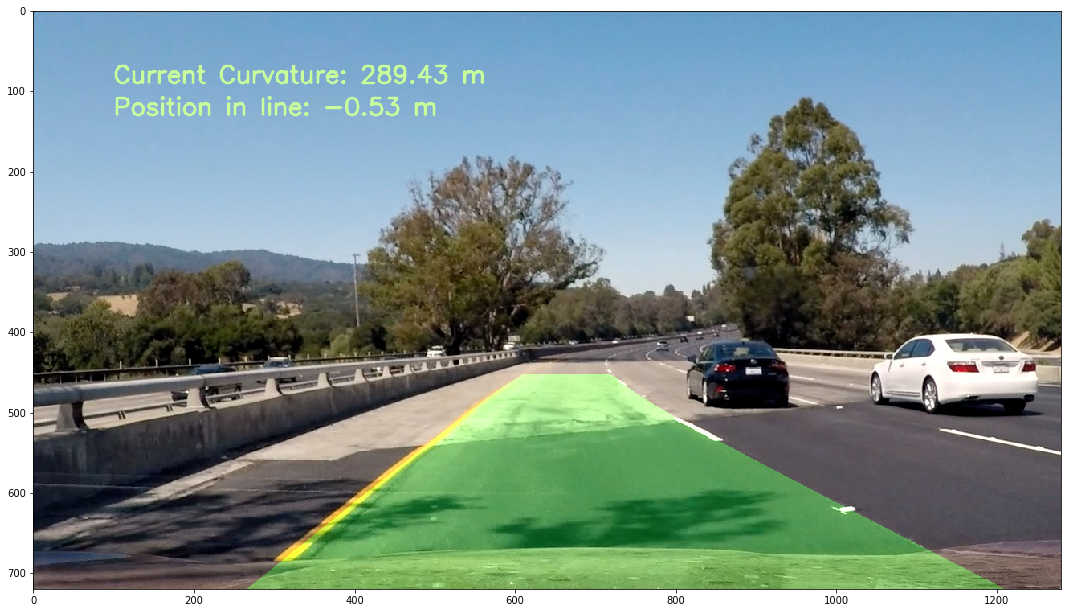

In [6]:
# Load an image for testing purposes:
fname = 'CarND-Advanced-Lane-Lines/test_images/test4.jpg'
img = mpimg.imread(fname)

f, ax1 = plt.subplots(1, 1, figsize=(15, 10))
f.tight_layout()
ax1.imshow(real_time_processing(img))
plt.show()
f.savefig('images/final_result.png')

Now, we are ready to record a video!

In [2]:
# Import everything needed to edit/save/watch video clips
path_to_video = '/home/carnd/Self-Driving-Car-ND/Term1/P4 - Advance Traffic Lines Recognition/CarND-Advanced-Lane-Lines/project_video.mp4'
create_video(path_to_video)


[MoviePy] >>>> Building video /home/carnd/Self-Driving-Car-ND/Term1/P4 - Advance Traffic Lines Recognition/CarND-Advanced-Lane-Lines/project_video_solved.mp4
[MoviePy] Writing video /home/carnd/Self-Driving-Car-ND/Term1/P4 - Advance Traffic Lines Recognition/CarND-Advanced-Lane-Lines/project_video_solved.mp4


100%|█████████▉| 1260/1261 [02:24<00:00,  8.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/carnd/Self-Driving-Car-ND/Term1/P4 - Advance Traffic Lines Recognition/CarND-Advanced-Lane-Lines/project_video_solved.mp4 



And here is the [video on Youtube](https://youtu.be/_mLMaHIXtFs).


## Discussion

This technique allows a decent approximation to measure road curvature and car position on the line. However, the approach is still quite limited, for example:
* Vehicles on front or heavy traffic might affect the lines recognition process
* Light conditions: This approach consider perfect light conditions as well as lines drawn on the road. There are plenty of scenarios where these conditions are not meet (adverse weather conditions, night light, etc)
* Road slope is assumed to be constant, of course this is not a real situation and different road slopes might affect the picture translation points. 

These three points would make the pipeline fail. Ways to improve this process would include a car recognition system to somehow exclude them from the analysis. For light conditions and road slope variations, car' sensors would be required. for example we could use radar or lidar measurements to identify road slopes and so perform image translations accordingly and for adverse visual conditions, probably these sensors would help recognizing road shape and surrounding cars.
